In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from bertopic import BERTopic

In [34]:
df= pd.read_csv("../Dataset/GPU_stock_dataset.csv", sep=';', quotechar='"', engine='python', skip_blank_lines=True, on_bad_lines='warn')

In [35]:
df.columns

Index(['Text', 'From-User', 'From-User-Id', 'To-User', 'To-User-Id',
       'Language', 'Source', 'Created-At', 'Geo-Location-Latitude',
       'Geo-Location-Longitude', 'Retweet-Count', 'Id'],
      dtype='object')

In [36]:
df.drop(columns=["From-User-Id", "To-User", "To-User-Id", "Source", "Geo-Location-Latitude", "Geo-Location-Longitude", "Language"], inplace=True)

In [37]:
df['Created-At']= pd.to_datetime(df['Created-At'], format='%Y-%m-%d %H:%M:%S')
df['Created-At'] = df['Created-At'].dt.date

In [38]:
df

,Text,From-User,Created-At,Retweet-Count,Id
0,: Amazon US: \nPowerColor Liquid Devil AMD Ra...,MoonKraken,2022-04-01,"1,0","1509819838935580000,0"
1,Amazon US: \nPowerColor Liquid Devil AMD Radeo...,GPU Stock Updater,2022-04-01,"1,0","1509818000010060000,0"
2,Amazon CA: \nEVGA GeForce GTX 1660 Black Gamin...,GPU Stock Updater,2022-04-01,",0","1509810397183990000,0"
3,Amazon US: \nASUS ROG Strix LC AMD Radeon™ RX ...,GPU Stock Updater,2022-04-01,",0","1509802771066800000,0"
4,Amazon US: \n...\n\nrtx3050 geforce gpustock g...,GPU Stock Updater,2022-04-01,",0","1509795354979490000,0"
...,...,...,...,...,...
2901,(US) In Stock: GIGABYTE GeForce X 3080 Ti Visi...,GPU Drops,2022-04-05,",0","1511412144557880000,0"
2902,Amazon CA: \nGIGABYTE GeForce X 3050 Eagle OC ...,GPU Stock Updater,2022-04-05,",0","1511411048863120100,0"
2903,Amazon US: \nGIGABYTE GeForce X 3050 Eagle OC ...,GPU Stock Updater,2022-04-05,",0","1511410955900620000,0"
2904,(US) In Stock: EVGA GeForce X 3070 Ti FTW3 Ult...,GPU Drops,2022-04-05,",0","1511410244408140000,0"


In [7]:
def clean_for_bert(text):
    import re
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)    # link
    text = re.sub(r"@\w+", "", text)              # mention
    text = re.sub(r"#", "", text)                 # remove #, but keep the word
    text = re.sub(r"\s+", " ", text).strip()      # extra spaces
    return text


In [8]:
df['Text'] = df['Text'].apply(clean_for_bert)

In [9]:
def HG_sentiment(df, column):
    """
    Calculate the sentiment of news articles using a Hugging Face model (distilBERT with 2 classes).
    Returns the dataframe with Sentiment, Score.
    """
    from transformers import pipeline

    # Convert to string
    df[column] = df[column].astype(str)

    # Initialize the pipeline
    sentiment_pipeline = pipeline(
        "sentiment-analysis", 
        model="distilbert-base-uncased-finetuned-sst-2-english"
    )

    # Apply the pipeline once for each text
    results = sentiment_pipeline(df[column].tolist(), truncation=True, max_length=512, batch_size=8) # truncate if too long

    results_df = pd.DataFrame(results)
    df['Sentiment'] = results_df['label'].str.lower()
    df['Score'] = results_df['score'].round(4)

    return df

In [10]:
df = HG_sentiment(df, 'Text')

Device set to use mps:0


In [11]:
df.head()

,Text,From-User,Created-At,Retweet-Count,Id,Sentiment,Score
0,: amazon us: powercolor liquid devil amd radeo...,MoonKraken,2022-04-01,"1,0","1509819838935580000,0",negative,0.9890
1,amazon us: powercolor liquid devil amd radeon ...,GPU Stock Updater,2022-04-01,"1,0","1509818000010060000,0",negative,0.9954
2,"amazon ca: evga geforce gtx 1660 black gaming,...",GPU Stock Updater,2022-04-01,",0","1509810397183990000,0",negative,0.9947
3,amazon us: asus rog strix lc amd radeon™ rx 69...,GPU Stock Updater,2022-04-01,",0","1509802771066800000,0",negative,0.9932
4,amazon us: ... rtx3050 geforce gpustock gpuale...,GPU Stock Updater,2022-04-01,",0","1509795354979490000,0",negative,0.9964


In [12]:
# Convert 'Created-At' in datetime with day and time
df['Created-At'] = pd.to_datetime(df['Created-At'])

# Convert 'Retweet-Count' and 'Id' to numbers (if they are strings with commas and decimals)
df['Retweet-Count'] = df['Retweet-Count'].astype(str).str.replace(",", "").astype(float)
df['Id'] = df['Id'].astype(str).str.replace(",", "").astype(float)


In [13]:
df.head()

,Text,From-User,Created-At,Retweet-Count,Id,Sentiment,Score
0,: amazon us: powercolor liquid devil amd radeo...,MoonKraken,2022-04-01,10.0,1.509820e+19,negative,0.9890
1,amazon us: powercolor liquid devil amd radeon ...,GPU Stock Updater,2022-04-01,10.0,1.509818e+19,negative,0.9954
2,"amazon ca: evga geforce gtx 1660 black gaming,...",GPU Stock Updater,2022-04-01,0.0,1.509810e+19,negative,0.9947
3,amazon us: asus rog strix lc amd radeon™ rx 69...,GPU Stock Updater,2022-04-01,0.0,1.509803e+19,negative,0.9932
4,amazon us: ... rtx3050 geforce gpustock gpuale...,GPU Stock Updater,2022-04-01,0.0,1.509795e+19,negative,0.9964


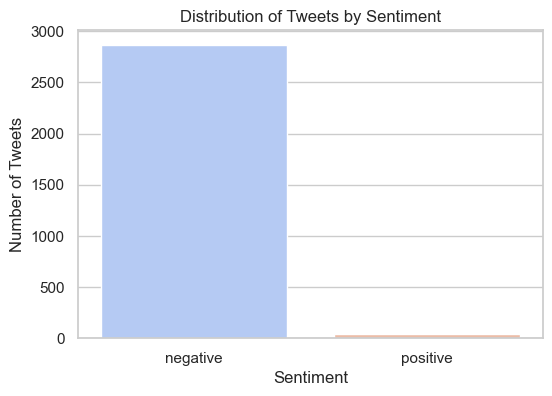

In [14]:
sns.set(style="whitegrid")

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Sentiment', hue='Sentiment', palette='coolwarm')
plt.title("Distribution of Tweets by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.show()


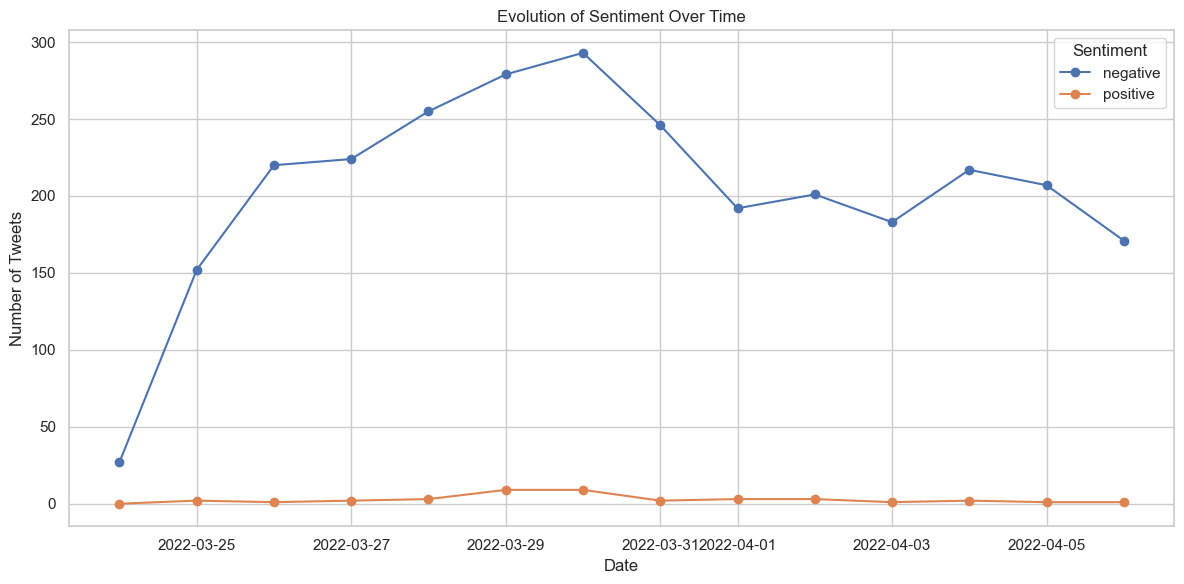

In [15]:
df['Created-At'] = pd.to_datetime(df['Created-At'])  # if not already done

# Count tweets by day and sentiment
sentiment_by_day = df.groupby([df['Created-At'].dt.date, 'Sentiment']).size().unstack(fill_value=0)

# Lineplot
sentiment_by_day.plot(figsize=(12,6), marker='o')
plt.title("Evolution of Sentiment Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.grid(True)
plt.tight_layout()
plt.show()


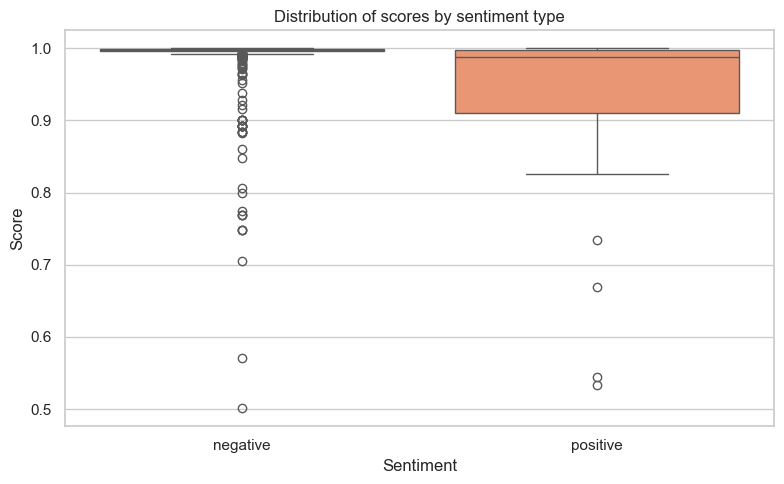

In [16]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='Sentiment', y='Score', palette='Set2', hue='Sentiment')
plt.title("Distribution of scores by sentiment type")
plt.tight_layout()
plt.show()


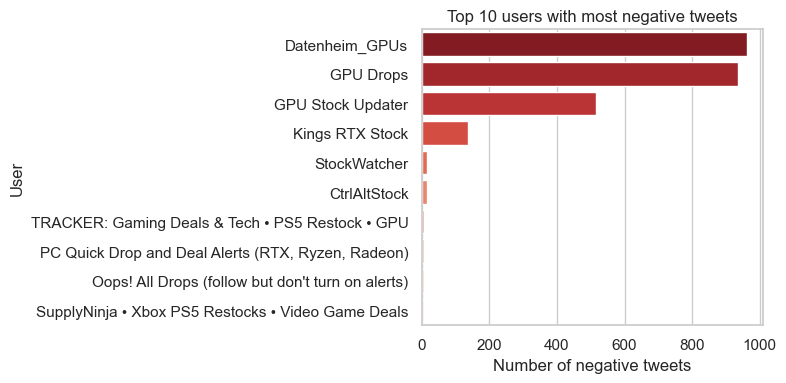

In [17]:
top_negative = df[df['Sentiment'] == 'negative']['From-User'].value_counts().head(10)

plt.figure(figsize=(8,4))
sns.barplot(y=top_negative.index, x=top_negative.values, palette='Reds_r', hue=top_negative.index)
plt.title("Top 10 users with most negative tweets")
plt.xlabel("Number of negative tweets")
plt.ylabel("User")
plt.tight_layout()
plt.show()


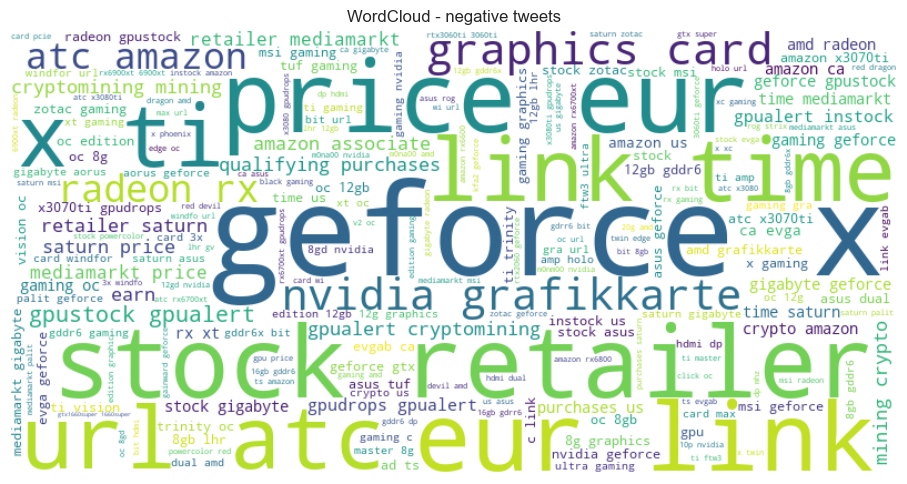

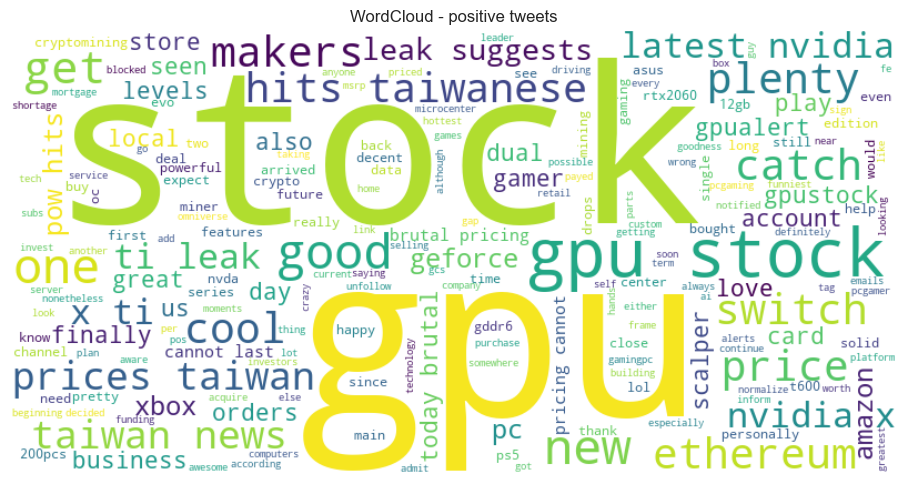

In [18]:
for label in df['Sentiment'].unique():
    text = " ".join(df[df['Sentiment'] == label]['Text'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=set(stopwords.words('english'))).generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud - {label} tweets")
    plt.tight_layout()
    plt.show()


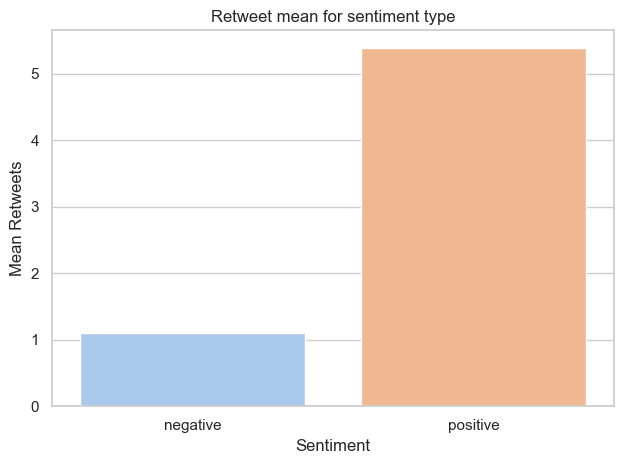

In [19]:
df['Retweet-Count'] = df['Retweet-Count'].astype(str).str.replace(",", "").astype(float)

retweet_avg = df.groupby('Sentiment')['Retweet-Count'].mean().reset_index()

sns.barplot(data=retweet_avg, x='Sentiment',hue='Sentiment', y='Retweet-Count', palette='pastel')
plt.title("Retweet mean for sentiment type")
plt.ylabel("Mean Retweets")
plt.tight_layout()
plt.show()


# Sentiment per brand


In [20]:
def exdract_brand(text):
    text = text.lower()
    if 'nvidia' in text or 'rtx' in text or 'geforce' in text:
        return 'NVIDIA'
    elif 'amd' in text or 'radeon' in text:
        return 'AMD'
    elif 'intel' in text:
        return 'Intel'
    else:
        return 'Altro'

df['Brand'] = df['Text'].astype(str).apply(exdract_brand)


In [21]:
brand_sentiment = df.groupby(['Brand', 'Sentiment']).size().reset_index(name='Count')


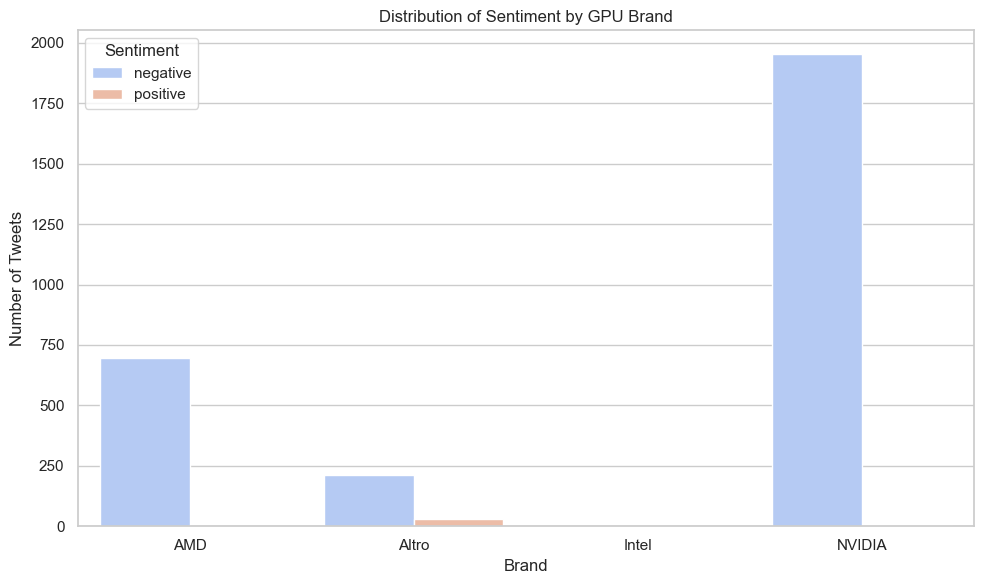

In [22]:
plt.figure(figsize=(10,6))
sns.barplot(data=brand_sentiment, x='Brand', y='Count', hue='Sentiment', palette='coolwarm')
plt.title("Distribution of Sentiment by GPU Brand")
plt.xlabel("Brand")
plt.ylabel("Number of Tweets")
plt.tight_layout()
plt.show()


<Axes: title={'center': '% of negative tweets by brand'}, xlabel='Brand'>

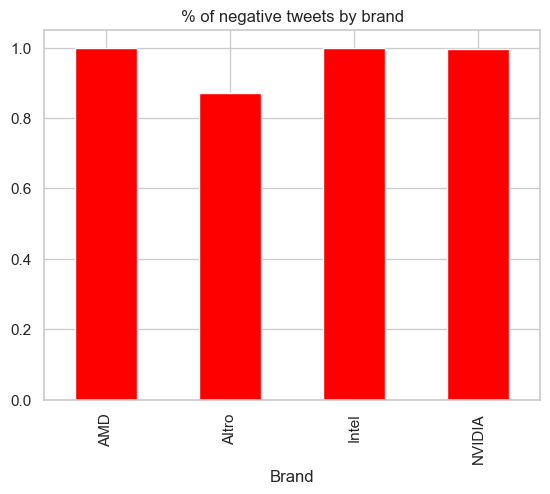

In [23]:
perc = brand_sentiment.pivot(index='Brand', columns='Sentiment', values='Count').fillna(0)
perc['Neg%'] = perc['negative'] / perc.sum(axis=1)
perc['Neg%'].plot(kind='bar', color='red', title='% of negative tweets by brand')


# Bertopic

In [24]:
def extract_topic_keywords(df, column, nr_topics):
    """
    Extract topic and keywords from a text column using BERTopic.

    Parameters:
    - df: DataFrame containing the data
    - column: name of the column with the text
    - nr_topics: maximum number of topics (optional)

    Returns:
    - topic_keywords: dictionary {topic_id: [keyword1, keyword2, ...]}
    - df with 'Topic_ID' column
    - model topic_model
    """
    from bertopic import BERTopic

        # 2. Preprocessing of text column
    df[column] = df[column].astype(str)
    df[column] = df[column].apply(clean_for_bert)

    docs = df[column].astype(str).tolist()
    
    topic_model = BERTopic(nr_topics=nr_topics, calculate_probabilities=True, verbose=True)
    topics, _ = topic_model.fit_transform(docs)

    # Map topics to keywords
    topic_keywords = {}
    for topic_id in set(topics):
        if topic_id == -1:
            continue  # skip outliers
        topic_data = topic_model.get_topic(topic_id)
        if topic_data and hasattr(topic_data, "__iter__"):
            topic_keywords[topic_id] = [word for word, _ in topic_data]
        else:
            topic_keywords[topic_id] = []

    df["Topic_ID"] = topics

    return topic_keywords, df, topic_model

In [25]:
topic_keywords, df_with_topics, topic_model = extract_topic_keywords(df, 'Text', nr_topics=10)

2025-07-31 16:12:20,702 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/91 [00:00<?, ?it/s]

2025-07-31 16:12:29,603 - BERTopic - Embedding - Completed ✓
2025-07-31 16:12:29,604 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-31 16:12:39,200 - BERTopic - Dimensionality - Completed ✓
2025-07-31 16:12:39,200 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-31 16:12:39,839 - BERTopic - Cluster - Completed ✓
2025-07-31 16:12:39,840 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-07-31 16:12:39,918 - BERTopic - Representation - Completed ✓
2025-07-31 16:12:39,918 - BERTopic - Topic reduction - Reducing number of topics
2025-07-31 16:12:39,960 - BERTopic - Topic reduction - Reduced number of topics from 104 to 10


In [26]:
topic_keywords

{0: ['url',
  'atc',
  'us',
  'amazon',
  'in',
  'stock',
  'earn',
  'qualifying',
  'purchases',
  'associate'],
 1: ['mining',
  'cryptomining',
  'crypto',
  'gpustock',
  'gpualert',
  'amazon',
  'radeon',
  'ca',
  'geforce',
  'graphics'],
 2: ['mediamarkt',
  'grafikkarte',
  'retailer',
  'eur',
  'time',
  'price',
  'now',
  'link',
  'nvidia',
  'in'],
 3: ['saturn',
  'eur',
  'retailer',
  'time',
  'grafikkarte',
  'price',
  'now',
  'link',
  'nvidia',
  'in'],
 4: ['gpu', 'the', 'to', 'and', 'are', 'stock', 'is', 'for', 'of', 'at'],
 5: ['evga',
  'evgabca',
  'ts',
  'ad',
  'amazonca',
  'link',
  'ultra',
  'ftw3',
  'gaming',
  'geforce'],
 6: ['core',
  'stores',
  'buy',
  'best',
  '8704',
  'advanced',
  '1710mhz',
  '1440mhz',
  'raytracing',
  'onlinein'],
 7: ['normalizes',
  'prepandemic',
  'plummet',
  'levels',
  'prices',
  'to',
  'gpu',
  'as',
  'stock',
  'horizon'],
 8: ['nvda',
  'ai',
  'analyst',
  'trends',
  'weighs',
  'spell',
  'slowing

# Plots

In [27]:
plt.figure(figsize=(10, 6))
topic_model.visualize_topics().show()

<Figure size 1000x600 with 0 Axes>

In [28]:
plt.figure(figsize=(10, 6))
topic_model.visualize_hierarchy().show()

<Figure size 1000x600 with 0 Axes>

In [29]:
plt.figure(figsize=(10, 6))
topic_model.visualize_barchart().show()

<Figure size 1000x600 with 0 Axes>

In [30]:
plt.figure(figsize=(10, 6))
topic_model.visualize_heatmap().show()

<Figure size 1000x600 with 0 Axes>

In [31]:
#topic labels
topic_labels = topic_model.get_topic_info()
topic_labels
# Assign topic labels to the DataFrame
topic_labels_dict = {row['Topic']: row['Name'] for _, row in topic_labels.iterrows()}
df['Topic_Label'] = df['Topic_ID'].map(topic_labels_dict)
df['Topic_Label'].value_counts()

Topic_Label
0_url_atc_us_amazon                        962
1_mining_cryptomining_crypto_gpustock      462
2_mediamarkt_grafikkarte_retailer_eur      400
3_saturn_eur_retailer_time                 393
-1_now_saturn_time_grafikkarte             328
4_gpu_the_to_and                           141
5_evga_evgabca_ts_ad                       127
6_core_stores_buy_best                      37
7_normalizes_prepandemic_plummet_levels     31
8_nvda_ai_analyst_trends                    25
Name: count, dtype: int64

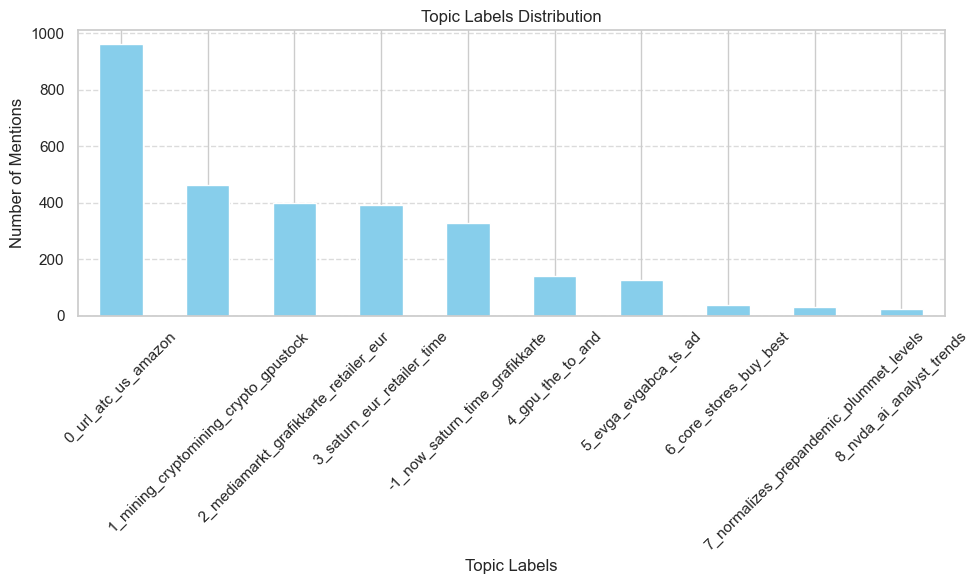

In [32]:
#plot topic labels
plt.figure(figsize=(10, 6))
df['Topic_Label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Topic Labels Distribution')
plt.xlabel('Topic Labels')
plt.ylabel('Number of Mentions')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()